In [131]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import SpatialDropout1D
import tensorflow as tf
import matplotlib.pyplot as plt

In [132]:
df=pd.read_csv('../data/ps5_tweets_text.csv')
df=df.rename(columns={'Tweet':'text'})
df

,Id,text
0,0,https://t.co/UpjxfOgQs8\r\r\n\r\r\nGaisss! Ple...
1,1,@mygovindia Today just after a week of lockdow...
2,2,Tuskys partners with Amref to provide on groun...
3,3,@chrissyteigen are u doing ur own grocery shop...
4,4,UK Critical Care Nurse Cries at Empty SuperMar...
...,...,...
37036,37036,Minnesota classifies grocery store workers as ...
37037,37037,US Senator @ewarren has asked for information ...
37038,37038,Just commented on @thejournal_ie: Poll: Are yo...
37039,37039,My wife got laid off yesterday because the sma...


In [133]:
labels_df=pd.read_csv('../data/ps5_tweets_labels_as_numbers.csv')
labels_df

,Id,Label
0,0,4
1,1,1
2,2,2
3,3,1
4,4,0
...,...,...
37036,37036,1
37037,37037,1
37038,37038,0
37039,37039,2


(array([ 4946.,     0.,  8930.,     0.,     0.,  6930.,     0., 10282.,
            0.,  5953.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

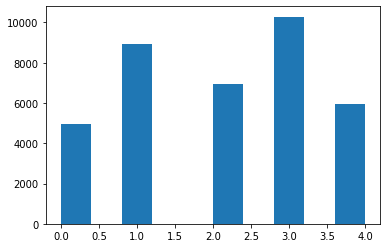

In [134]:
plt.hist(labels_df.Label)

In [135]:
df.isna().sum()

Id      0
text    0
dtype: int64

In [136]:
df['text'] = df['text'].apply(lambda x: re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', x))
df['text'] = df['text'].apply(lambda x: re.sub('@[^\s]+', 'AT_USER', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'#([^\s]+)', r'\1', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\n', r' ', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\r', r' ', x))
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [137]:
df

,Id,text
0,0,url gaisss please read thisand please lim...
1,1,at_user today just after a week of lockdown lo...
2,2,tuskys partners with amref to provide on groun...
3,3,at_user are u doing ur own grocery shopping no...
4,4,uk critical care nurse cries at empty supermar...
...,...,...
37036,37036,minnesota classifies grocery store workers as ...
37037,37037,us senator at_user has asked for information a...
37038,37038,just commented on at_user poll are you doing m...
37039,37039,my wife got laid off yesterday because the sma...


In [138]:
tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(df['text'].values)

In [139]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)

In [140]:
Y=pd.get_dummies(labels_df['Label'].values)

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 36)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.10, random_state = 36)

In [142]:
batch_size = 32
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 128)           320000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 985       
Total params: 575,785
Trainable params: 575,785
Non-trainable params: 0
_________________________________________________________________
None


In [143]:
history=model.fit(X_train, Y_train, batch_size =batch_size,epochs=20,  verbose = 1, validation_data=(X_val,Y_val),callbacks=tf.keras.callbacks.EarlyStopping(patience=3))

Epoch 1/20
834/834 [==============================] - 228s 267ms/step - loss: 1.3984 - accuracy: 0.3756 - val_loss: 0.9763 - val_accuracy: 0.6275
Epoch 2/20
834/834 [==============================] - 191s 229ms/step - loss: 0.8953 - accuracy: 0.6636 - val_loss: 0.9123 - val_accuracy: 0.6748
Epoch 3/20
834/834 [==============================] - 196s 235ms/step - loss: 0.8273 - accuracy: 0.7046 - val_loss: 0.9005 - val_accuracy: 0.6727
Epoch 4/20
834/834 [==============================] - 195s 234ms/step - loss: 0.7900 - accuracy: 0.7178 - val_loss: 0.8705 - val_accuracy: 0.6906
Epoch 5/20
834/834 [==============================] - 191s 229ms/step - loss: 0.7315 - accuracy: 0.7346 - val_loss: 0.8604 - val_accuracy: 0.6913
Epoch 6/20
834/834 [==============================] - 193s 232ms/step - loss: 0.7164 - accuracy: 0.7441 - val_loss: 0.8615 - val_accuracy: 0.6974
Epoch 7/20
834/834 [==============================] - 206s 247ms/step - loss: 0.6583 - accuracy: 0.7634 - val_loss: 0.8593 -

In [154]:
score,acc=model.evaluate(X_test,Y_test,batch_size=batch_size,verbose=5)

In [155]:
print(acc)

0.6956404447555542


In [146]:
y_pred=model.predict(X_test,batch_size=batch_size,verbose=5)

In [147]:
from sklearn.metrics import classification_report

In [148]:
y_pred_bool = np.argmax(y_pred, axis=1)

In [149]:
Y_test_reset=Y_test.reset_index()

In [150]:
Y_test_reset

,index,0,1,2,3,4
0,22941,1,0,0,0,0
1,31108,0,0,0,0,1
2,16858,0,0,0,1,0
3,13328,1,0,0,0,0
4,23267,0,0,1,0,0
...,...,...,...,...,...,...
7404,6780,0,0,0,1,0
7405,32621,0,0,0,1,0
7406,4846,0,0,0,1,0
7407,7871,0,0,0,1,0


In [151]:
labels=[]
for row in range(len(Y_test_reset)):
    if Y_test_reset.iloc[row,1]==1:
        labels.append(0)
    elif Y_test_reset.iloc[row,2]==1:
        labels.append(1)
    elif Y_test_reset.iloc[row,3]==1:
        labels.append(2)
    elif Y_test_reset.iloc[row,4]==1:
        labels.append(3)
    else:
        labels.append(4)

In [152]:
print(classification_report(labels,y_pred_bool))

              precision    recall  f1-score   support

           0       0.76      0.62      0.69       995
           1       0.62      0.64      0.63      1786
           2       0.75      0.76      0.75      1417
           3       0.66      0.70      0.68      2013
           4       0.78      0.74      0.76      1198

    accuracy                           0.70      7409
   macro avg       0.71      0.69      0.70      7409
weighted avg       0.70      0.70      0.70      7409



In [175]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(labels,y_pred_bool)

In [174]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

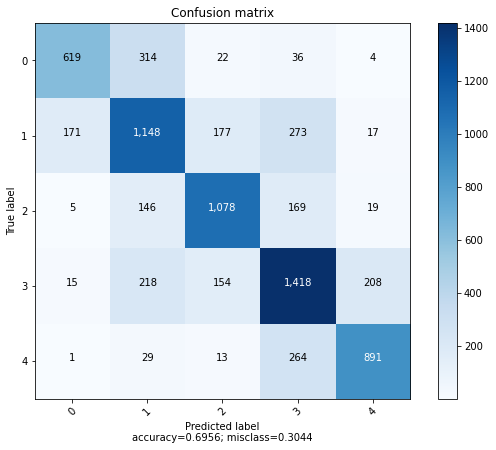

In [177]:
plot_confusion_matrix(cm,[0,1,2,3,4],normalize=False)